In [1]:
import qutip as qt
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

import matplotlib.ticker as ticker


from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm
from scipy.integrate import simpson

%matplotlib inline

In [2]:



plt.rcParams.update({
    "text.usetex": True,
    #"text.latex.preamble": r"\boldmath",
    #"font.family": "sans-serif",
    "mathtext.fontset" : "stix",
    "font.family" : "lmodern", #   "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #"text.latex.preamble": r"\usepackage[T1]{fontenc}  \usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.4,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.4,     # distance to the minor tick label in points
    #
    "xtick.major.size": 5.5, 
    "ytick.major.size": 5.5,
    
    "xtick.minor.size": 3.5, 
    "ytick.minor.size": 3.5,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "white",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})



In [3]:
### Functions for evaluating the dominant eigenvalue

def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
    else: raise ValueError('You have to choose or left or right')
         
    # Get the maximum eigenvalue and its corresponding index
    dominant_e, idx = Get_maximum(e_values)

    # Get dimension
    d = int(np.sqrt(np.shape(Ws)[0]))
    
    # reshaping the result
    e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
    # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
    return e_values[idx], e_mat/np.trace(e_mat)

In [4]:

def Apply_Tilted_lindblad_normed(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    drho -= rho * np.trace(np.reshape(drho, (2,2)))

    
    # Return the time derivative of rho, flattened back to a 1D array
    return drho


def Apply_Tilted_lindblad(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    # Return the time derivative of rho, flattened back to a 1D array
    return drho

# Model

In [5]:
H0 = (qt.qeye(2) + qt.sigmaz())/2
H1 = qt.sigmax()

Lm = qt.sigmam()
Lp = qt.sigmap()

######## Parameters 

laser = 1.0
tempe = 0.5
omega = 1.0
gamma = 1.0

n_occ = 0 # 1.0/(np.exp(omega/tempe) - 1)

######### Driving 

def driving(t, args):
    t_half = args["tau"]/2
    if t < t_half:
        return args["laser"]*np.cos(np.pi*(t/(t_half)))
    else:
        return args["laser"]*np.sin(np.pi*(t/(t_half)))
        
H = [H0, [H1, driving]]

c_ops = [np.sqrt(gamma * (n_occ + 1))*Lm, np.sqrt(gamma * n_occ)*Lp]


rho0 = (1/2)*(qt.basis(2,0)+qt.basis(2,1))*(qt.basis(2,1).dag() + qt.basis(2,0).dag())
rho0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

In [6]:
####
#### Defining the operators in the vector form
####

Ide = qt.qeye(2)

Flat_state = np.ravel(Ide.full())

# The components of the tilted map

Flat_H0    = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()  

Flat_H1    = -1.0j*(qt.tensor(Ide, H1) - qt.tensor(H1.trans(), Ide)).full()  

Flat_inco_m = -(1.0/2.0)*(qt.tensor(Ide, Lm.dag()*Lm) + qt.tensor((Lm.dag()*Lm).trans(), Ide)).full()

Flat_inco_p = -(1.0/2.0)*(qt.tensor(Ide, Lp.dag()*Lp) + qt.tensor((Lp.dag()*Lp).trans(), Ide)).full()

Flat_jump_m = (qt.tensor(Lm.conj(),Lm)).full()

Flat_jump_p = (qt.tensor(Lp.conj(),Lp)).full()

#### Definig the functions 

def Tilted_lindbladian(t, args):
    n_occ = 1.0/(np.exp(args["omega"]/args["tempe"]) - 1)

    Wst = (Flat_H0 * args["omega"]
         + Flat_H1 * driving(t, args)
         + Flat_inco_m * (args["gamma"] * (n_occ + 1)) 
         + Flat_inco_p * (args["gamma"] * (n_occ + 0))
         + Flat_jump_m * (args["gamma"] * (n_occ + 1)) * np.exp(-args["sm"])#*args["omega"]/args["tempe"])
         + Flat_jump_p * (args["gamma"] * (n_occ + 0)) * np.exp(-args["sp"]))#*args["omega"]/args["tempe"]))
    
    return Wst.astype(complex)
              

## Evaluating convergence 

In [7]:
sm = 0.5
sp = 0.5

tau = 100
Nsteps = 5000
tlist = np.linspace(0, tau, Nsteps)


args  = {"sm":sm,
         "sp":sp,
         "laser":laser,
         "tempe":tempe,
         "omega":omega,
         "gamma":gamma,
         "tau":tau}

#### Exact diagonalization 
e_vals = []
e_vecs = []


for t in tlist:
    Ws = Tilted_lindbladian(t, args)
    e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
    e_vals.append(e_val)
    e_vecs.append(qt.Qobj(e_vec))

In [8]:
##
## Fig a) 
##

taus = [1, 10, 100]
Fidelity_list = []
Tlist_list = []
rho0_int = np.array(rho0,dtype=np.complex_).flatten()

for tau in taus:
    tlist = np.linspace(0, tau, Nsteps)
    args["tau"] = tau
    args_int = (args, )
    t_span = (0, tau)

    sol = solve_ivp(Apply_Tilted_lindblad_normed, 
                (0, tau), 
                rho0_int, 
                t_eval=tlist, 
                args=(args, ), 
                method="DOP853", 
                rtol=10e-14, 
                atol=10e-16)
    
    e_vals = []
    e_vecs = []
    for t in tlist:
        Ws = Tilted_lindbladian(t, args)
        e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
        e_vals.append(e_val)
        e_vecs.append(qt.Qobj(e_vec))
    
    states_int = [qt.Qobj(state.reshape((2,2))) for state in sol.y.transpose()]

    Fidelity_list.append([qt.fidelity(states_int[i], e_vecs[i]) for i in range(Nsteps)])
    Tlist_list.append(tlist)
    


In [13]:

##########
########## Evaluating the Inset in Fig a) 
##########



slist = [-0.5, 0, 0.5]

def Fidelity_taulist_s(args, slist):
    
    Fidelity_taulist_s = []

    tau_list = np.logspace(-2, 2.3, 100)
    args["tau"] = 1

    for s in slist:
        args["sm"] = s 
        args["sp"] = s 
        
        Ws = Tilted_lindbladian(t, args)
        e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
        rho_final = qt.Qobj(e_vec)
        
        Fidelity_taulist = []

        for tau in tau_list:
    
            tlist = np.linspace(0, tau, Nsteps)
            args["tau"] = tau
            args_int = (args, )
            t_span = (0, tau)

            sol = solve_ivp(Apply_Tilted_lindblad_normed, 
                            (0, tau), 
                            rho0_int, 
                            t_eval=tlist, 
                            args=(args, ), 
                            method="DOP853", 
                            rtol=10e-12, 
                            atol=10e-14)
            print(sol.success, tau)
    
            evolved_rho = [qt.Qobj(sol.y.transpose()[i].reshape((2,2))) for i, t in enumerate(tlist)]

    
            Ws_list = [Tilted_lindbladian(t, args) for t in tlist]
            e_vec_list = [Numeric_diagonalization(Ws, side="right")[1] for Ws in Ws_list]
            rho_list = [qt.Qobj(e_vec) for e_vec in e_vec_list]
    
            Fidelity_tlists = [qt.fidelity(rho_list[i], evolved_rho[i]) for i, t in enumerate(tlist)]
    
            Fidelity_taulist.append(simpson(Fidelity_tlists, tlist)/tau)
        Fidelity_taulist_s.append(Fidelity_taulist)
    return tau_list, Fidelity_taulist_s
    
    
tau_list, FTs = Fidelity_taulist_s(args, slist)

True 0.01
True 0.011051833753184675
True 0.012214302930803203
True 0.01349904454022734
True 0.014918919608542781
True 0.01648814192907418
True 0.018222420349904147
True 0.020139116028778995
True 0.02225741622861623
True 0.02459852639341012
True 0.027185882427329403
True 0.030045385302046933
True 0.03320566034086008
True 0.03669834377519034
True 0.04055839944206232
True 0.044824468792893084
True 0.04953925771738691
True 0.054749964054873076
True 0.06050875007272942
True 0.06687326464168065
True 0.07390722033525775
True 0.08168103123052588
True 0.09027251779484574
True 0.09976768591500403
True 0.11026158786725687
True 0.12185927384710872
True 0.13467684358420512
True 0.1488426085696291
True 0.16449837653018815
True 0.1818008710080415
True 0.20092330025650468
True 0.22205709115760974
True 0.24541380551896774
True 0.2712272579332027
True 0.2997558564009895
True 0.33128518914872357
True 0.3661308835364033
True 0.40464176567509486
True 0.4472033523836257
True 0.4942417104410697
True 0.546227

In [14]:
####
#### Evaluating numerically the exact theta
####

s_list = np.linspace(-1, 1, 100)

exact_theta = []
for s in s_list:
    tlist = np.linspace(0, 1, Nsteps)
    args["tau"] = 1
    args["sm"] = s
    args["sp"] = s
    e_vals = []

    for t in tlist:
        Ws = Tilted_lindbladian(t, args)
        e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
        e_vals.append(e_val)

    exact_theta.append(simpson(e_vals, tlist))

In [15]:
Tlist_list = []
rho0_int = np.array(rho0,dtype=np.complex_).flatten()

taus = [1, 10, 100]

thetas = []
for tau in taus:
    aux = []
    for s in s_list:
        tlist = np.linspace(0, tau, Nsteps)
        args["tau"] = tau
        args["sm"] = s
        args["sp"] = s
        args_int = (args, )
        t_span = (0, tau)

        sol = solve_ivp(Apply_Tilted_lindblad, 
                    (0, tau), 
                    rho0_int, 
                    t_eval=tlist, 
                    args=(args, ), 
                    method="DOP853", 
                    rtol=10e-12, 
                    atol=10e-14)
        print(sol.success)
        evolved_rho = qt.Qobj(sol.y.transpose()[-1].reshape((2,2)))
        aux.append((1/tau)*np.log(evolved_rho.tr()))
    Tlist_list.append(np.linspace(0, tau, Nsteps))    
    thetas.append(aux)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


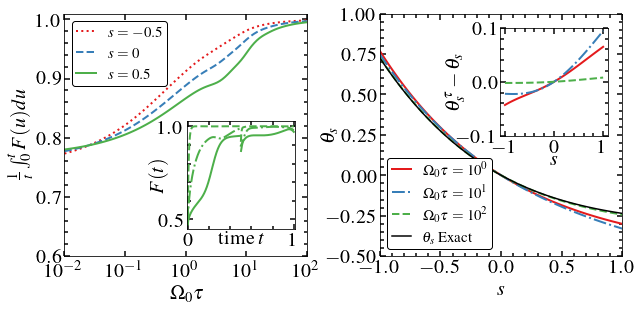

In [26]:

fig, ax = plt.subplots(1,2, figsize=(10,5))

#######################



##########




ax[0].plot(tau_list,FTs[0], color="#e41a1c", linestyle=":", label=r"$s=-0.5$", linewidth=2)
ax[0].plot(tau_list,FTs[1], color="#377eb8", linestyle="--", label=r"$s=0$", linewidth=2)
ax[0].plot(tau_list,FTs[2], color="#4daf4a", linestyle="-", label=r"$s=0.5$", linewidth=2)

ax[0].set_xlabel(r"$\Omega_0\tau$")
ax[0].set_ylabel(r"$\frac{1}{t} \int_0^tF(u)du$")
ax[0].set_xscale("log")

ax[0].set_xticks([0.01, 0.1, 1, 10, 100])

ax[0].tick_params(axis='x', pad=7)

ax[0].set_ylim((0.6, 1.01))
ax[0].set_xlim((0.01, 100))


ax[0].set_box_aspect(1)

ax[0].legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=2)





left0, bottom0, width0, height0 = [0.24, 0.24, 0.26, 0.3]
ax0 = fig.add_axes([left0, bottom0, width0, height0])

ax0.plot(Tlist_list[0][:int(Nsteps/2)]/max(Tlist_list[0]), Fidelity_list[0][:int(Nsteps/2)], color="#4daf4a", label=r"$\Omega_0\tau=10^0$", linestyle="-" , linewidth=2)
ax0.plot(Tlist_list[1][:int(Nsteps/2)]/max(Tlist_list[1]), Fidelity_list[1][:int(Nsteps/2)], color="#4daf4a", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax0.plot(Tlist_list[2][:int(Nsteps/2)]/max(Tlist_list[2]), Fidelity_list[2][:int(Nsteps/2)], color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax0.plot(Tlist_list[0][int(Nsteps/2):]/max(Tlist_list[0]), Fidelity_list[0][int(Nsteps/2):], color="#4daf4a",linestyle="-" , linewidth=2)
ax0.plot(Tlist_list[1][int(Nsteps/2):]/max(Tlist_list[1]), Fidelity_list[1][int(Nsteps/2):], color="#4daf4a",linestyle="-.", linewidth=2)
ax0.plot(Tlist_list[2][int(Nsteps/2):]/max(Tlist_list[2]), Fidelity_list[2][int(Nsteps/2):], color="#4daf4a",linestyle="--", linewidth=2)


ax0.set_xlabel(r"time $t$", labelpad=-20)
ax0.set_ylabel(r"$F(t)$", labelpad=-10)
ax0.set_box_aspect(1)

ax0.set_xlim((-0.01, 1.01))


#ax0.set_box_aspect(1)

ax[1].plot(s_list, thetas[0],color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-", linewidth=2)
ax[1].plot(s_list, thetas[1],color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax[1].plot(s_list, thetas[2],color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax[1].plot(s_list, exact_theta, color="black", label=r"$\theta_s$ Exact")

ax[1].set_xlabel(r"$s$")
ax[1].set_ylabel(r"$\theta_s$", labelpad=-12)
ax[1].set_ylim((-0.5,1))
ax[1].set_xlim((-1,1))

ax[1].set_box_aspect(1)


ax[1].legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=3)

left1, bottom1, width1, height1 = [0.63, 0.50, 0.35, 0.3]
ax1 = fig.add_axes([left1, bottom1, width1, height1])
ax1.set_box_aspect(1)


#ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[0])),color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-", linewidth=2)
#ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[1])),color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
#ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[2])),color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)


ax1.plot(s_list, (np.array(exact_theta)-np.array(thetas[0])),color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-", linewidth=2)
ax1.plot(s_list, (np.array(exact_theta)-np.array(thetas[1])),color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax1.plot(s_list, (np.array(exact_theta)-np.array(thetas[2])),color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax1.set_ylabel(r"$\theta_s^\tau - \theta_s$", labelpad=-8)
#ax1.plot(s_list, exact_theta, color="black")

ax1.set_xlabel(r"$s$", labelpad=-6)

ax1.set_ylim((-0.1, 0.1))

plt.subplots_adjust(wspace=0.3)

plt.savefig("Fig2.pdf", bbox_inches="tight")



/Users/paulo/miniconda3/envs/science/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


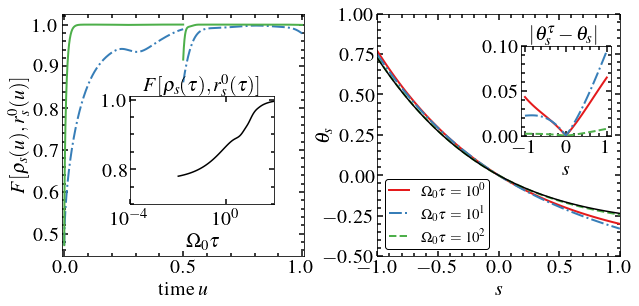

In [66]:

fig, ax = plt.subplots(1,2, figsize=(10,5))

#######################



##########
#ax[0].plot(Tlist_list[0][:int(Nsteps/2)]/max(Tlist_list[0]), Fidelity_list[0][:int(Nsteps/2)], color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-" , linewidth=2)
ax[0].plot(Tlist_list[1][:int(Nsteps/2)]/max(Tlist_list[1]), Fidelity_list[1][:int(Nsteps/2)], color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax[0].plot(Tlist_list[2][:int(Nsteps/2)]/max(Tlist_list[2]), Fidelity_list[2][:int(Nsteps/2)], color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="-", linewidth=2)

#ax[0].plot(Tlist_list[0][int(Nsteps/2):]/max(Tlist_list[0]), Fidelity_list[0][int(Nsteps/2):], color="#e41a1c",linestyle="-" , linewidth=2)
ax[0].plot(Tlist_list[1][int(Nsteps/2):]/max(Tlist_list[1]), Fidelity_list[1][int(Nsteps/2):], color="#377eb8",linestyle="-.", linewidth=2)
ax[0].plot(Tlist_list[2][int(Nsteps/2):]/max(Tlist_list[2]), Fidelity_list[2][int(Nsteps/2):], color="#4daf4a",linestyle="-", linewidth=2)


ax[0].set_xlabel(r"time $u$")
ax[0].set_ylabel(r"$F[\rho_s(u), r_s^0(u)]$")

ax[0].set_xlim((-0.01, 1.01))
#ax[0].legend(edgecolor="black", framealpha=1,handlelength=0.7,borderpad=0.4)

ax[0].set_box_aspect(1)


left0, bottom0, width0, height0 = [0.22, 0.31, 0.2, 0.3]
ax0 = fig.add_axes([left0, bottom0, width0, height0])

ax0.plot(tau_list,np.array(Fidelity_taulist)/tau_list, color="black")
ax0.set_xlabel(r"$\Omega_0\tau$")
ax0.set_title(r"$F[\rho_s(\tau), r_s^0(\tau)]$")
ax0.set_xscale("log")

ax0.tick_params(axis='x', pad=7)

ax0.set_ylim((0.7, 1.01))
ax0.set_xlim((0.0001, 100))

#ax0.set_box_aspect(1)

ax[1].plot(s_list, thetas[0],color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-", linewidth=2)
ax[1].plot(s_list, thetas[1],color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax[1].plot(s_list, thetas[2],color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax[1].plot(s_list, exact_theta, color="black")

ax[1].set_xlabel(r"$s$")
ax[1].set_ylabel(r"$\theta_s$", labelpad=-10)
ax[1].set_ylim((-0.5,1))
ax[1].set_xlim((-1,1))

ax[1].set_box_aspect(1)


ax[1].legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=3)

left1, bottom1, width1, height1 = [0.7, 0.50, 0.25, 0.25]
ax1 = fig.add_axes([left1, bottom1, width1, height1])
ax1.set_box_aspect(1)


ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[0])),color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-", linewidth=2)
ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[1])),color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[2])),color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax1.set_title(r"$|\theta_s^\tau - \theta_s|$")
#ax1.plot(s_list, exact_theta, color="black")

ax1.set_xlabel(r"$s$")

ax1.set_ylim((0.0, 0.1))

plt.subplots_adjust(wspace=0.3)

plt.savefig("Fig2.pdf", bbox_inches="tight")

